In [1]:
from six.moves import cPickle
import cv2
import numpy as np
from scipy.signal import convolve2d
import theano
import gym
from gym import wrappers
import theano
import theano.tensor as T
import lasagne

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 5105)
/home/etoestja/venv/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
from lasagne.layers.dnn import Conv3DDNNLayer
from lasagne.layers.dnn import Pool3DDNNLayer

In [25]:
def average(pixel):
    return (pixel[:, :, 0] + pixel[:, :, 1] + pixel[:, :, 2]) / 3

def weightedAverage(pixel):
    return 0.299 * pixel[:, :, 0] + 0.587 * pixel[:, :, 1] + 0.114 * pixel[:, :, 2]

In [2]:
def _process_frame42(frame):
    frame = frame[34:34+160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (42, 42))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [42, 42, 1])
    return frame

In [36]:
dtensor = T.TensorType('float32' ,(False,)*5)

In [46]:
def CreateNeuralNetwork(input_object, num_filters=10, filter_size=5, width=16, learning_rate=0.0001):
    input_var = dtensor('inputs')
    target_var = dtensor('targets')
    network = lasagne.layers.InputLayer(shape=(None, 1, 4, input_object.shape[3], input_object.shape[4]),
                                        input_var=input_var)
    network = Conv3DDNNLayer(network, num_filters, (2, 5, 5))
    network = Conv3DDNNLayer(network, num_filters, (2, 5, 5))
    network = lasagne.layers.DenseLayer(network, width, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    coded_features = lasagne.layers.get_output(network, deterministic=True)
    coded_features_fn = theano.function([input_var], coded_features)

    network_out = lasagne.layers.ReshapeLayer(network, (1, 1, 4, 4))
    network_out = lasagne.layers.Upscale2DLayer(network_out, 2)
    network_out = lasagne.layers.Upscale2DLayer(network_out, 2)
    network_out = lasagne.layers.Upscale2DLayer(network_out, 2)
    network_out = lasagne.layers.Upscale2DLayer(network_out, 2)
    network_out = lasagne.layers.TransposedConv2DLayer(network_out, num_filters, 3)
    network_out = lasagne.layers.TransposedConv2DLayer(network_out, num_filters, 3)
    network_out = lasagne.layers.FeaturePoolLayer(network_out, num_filters)

    # functions:
    prediction = lasagne.layers.get_output(network_out)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    loss = loss.mean()

    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.rmsprop(loss, params, learning_rate=learning_rate)
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction, target_var)
    test_loss = test_loss.mean()
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    val_fn = theano.function([input_var, target_var], test_loss)
    prediction_fn = theano.function([input_var], test_prediction)
    
    return coded_features_fn, val_fn, train_fn

In [38]:
np.array(observation_frame).shape

(4, 250, 160)

In [47]:
coded_features_fn, val_fn, train_fn = CreateNeuralNetwork(np.array([[observation_frame]]))

INFO (theano.gof.compilelock): Refreshing lock /home/etoestja/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.6--2.7.9-64/lock_dir/lock
[2017-02-07 23:44:53,082] Refreshing lock /home/etoestja/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.6--2.7.9-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/etoestja/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.6--2.7.9-64/lock_dir/lock
[2017-02-07 23:45:53,514] Refreshing lock /home/etoestja/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.6--2.7.9-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/etoestja/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.6--2.7.9-64/lock_dir/lock
[2017-02-07 23:46:59,677] Refreshing lock /home/etoestja/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.6--2.7.9-64/lock_dir/lock


KeyboardInterrupt: 

In [33]:
np.array([[observation_frame]]).shape

(1, 1, 4, 250, 160)

In [104]:
target_fn(np.array([[observation_frame]]).astype('float32')).shape

(1, 1, 42, 42)

In [9]:
np.array(observation_frame).shape

(4, 42, 42)

In [5]:
env = gym.make("Skiing-v0")

[2017-02-07 23:24:40,244] Making new env: Skiing-v0


In [29]:
observation = env.reset()
done = False
iteration, all_reward = 0, 0
observation_frame = []
while not done:
    #env.render()
    observation, reward, done, info = env.step(env.action_space.sample())
    observation_frame += [average(observation)]
    if len(observation_frame) > 4:
        observation_frame.pop(0)
    print(len(observation_frame))
    all_reward += reward
    # if iteration % 500 == 0:
    # print(str(iteration) + "... ")

    if all_reward < -1000 or iteration >= 8000:
            break

    iteration += 1

print "Reward: ", all_reward

1
2
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
Reward:  -1007.0


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

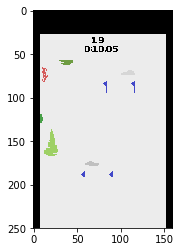

In [30]:
plt.imshow(observation)

In [17]:
average(observation).shape

(160, 3)

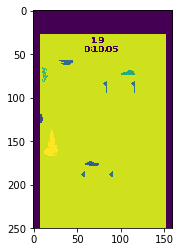

In [31]:
plt.imshow(average(observation))

In [28]:
average(observation).shape

(250, 160)